In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.preprocessing import MultiLabelBinarizer
from preprocessing import TagGrouper, MultilabelFeatureSelector
from plotting import plot_multilabel_classification_report, plot_multilabel_precision_recall, plot_multilabel_roc
from persistence import load_all_classifiers
from baseline import BASELINE_FEATURE_COLUMNS

/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Load classifiers
classifiers = load_all_classifiers('models-baseline-0c25f9f')

Loading model tag_1
Loading model tag_11
Loading model tag_12
Loading model tag_2
Loading model tag_3
Loading model tag_5
Loading model tag_6
Loading model tag_9


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---
## Import Dataset

In [3]:
# Import dataset
df = pd.read_csv('./data/features-0c25f9f.csv', index_col='revision_id')
tag_df = pd.read_csv('./data/tag.csv', index_col='id')
df.head()

,isContributorAnonymous,isBot,timeOfDay,localizedTimeOfDay,dayOfWeek,localizedDayOfWeek,isMinorEdit,hasPreviousSameContributor,timeSinceLastArticleEdit,timeSinceLastArticleEditBySameContributor,...,userCommentLength,hasNumericOutlierInColumns,hasNumericOutlierInRows,hasNumericOutlierInChangedCellValues,tableDataTypeInformationGain,templateUseFlags,templateUseFifaFlags,templateUsePageLink,templateUseYesNo,tag_id
revision_id,,,,,,,,,,,,,,,,,,,,,
228189784,0.0,0.0,13.0,-1.0,7.0,-1.0,0.0,0.0,-1.0,-1.0,...,34.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
730449352,0.0,0.0,2.0,-1.0,2.0,-1.0,0.0,1.0,25.0,25.0,...,0.0,1.0,0.0,0.0,0.134129,0.0,0.0,0.0,0.0,12
216224416,0.0,0.0,17.0,-1.0,6.0,-1.0,1.0,0.0,7837.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12
539338621,0.0,1.0,1.0,-1.0,4.0,-1.0,1.0,0.0,2108.0,-1.0,...,0.0,0.0,0.0,0.0,-1.000000,0.0,0.0,0.0,0.0,12
746191686,1.0,0.0,20.0,23.0,2.0,2.0,0.0,0.0,4077.0,-1.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,12


/Users/philipphager/.local/share/virtualenvs/vandalism-classifier-WHUGQZpq/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


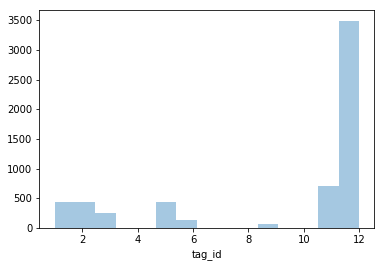

In [4]:
# Tag distribution
sns.distplot(df['tag_id'], kde=False)
plt.show()

---
## Preprocessing

In [5]:
def preprocessing(frame, features):
    feature_columns = None
    
    if features == 'baseline':
        feature_columns = BASELINE_FEATURE_COLUMNS

    preprocess_pipeline = Pipeline([
        ('feature_selector', MultilabelFeatureSelector(feature_columns)),
        ('tag_grouper', TagGrouper())
    ])

    return preprocess_pipeline.transform(frame)\
        .fillna(0)


def flatten_multilabel_predict(y_score):
    result = []
    for i in range(len(y_score[0])):
        row = []
        for l in range(len(y_score)):
            row.append(y_score[l][i]) 
        result.append(row)
    return np.array(result)


def flatten_multilabel_predict_proba(y_score):
    result = []
    for i in range(len(y_score[0])):
        row = []
        for l in range(len(y_score)):
            row.append(y_score[l][i][1]) 
        result.append(row)
    return np.array(result)


tags = [1, 2, 3, 5, 6, 9, 11, 12]
tag_names = ['blanking', 'nonesense', 'quality issue', 'false fact', 'syntax', 'edit war', 'intention', 'constructive']
print('Selected tags', tags)

Selected tags [1, 2, 3, 5, 6, 9, 11, 12]


In [6]:
processed_df = preprocessing(df, 'baseline')
processed_df.head()

/Users/philipphager/Developer/uni/semester-3/vandalism-detection/wikipedia-table-vandalism-detection/vandalism-classifier/preprocessing.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['all_tags'] = X.groupby(['revision_id'])['tag_id'].apply(list)


,isContributorAnonymous,rawCommentLength,sizeChange,timeSinceLastArticleEdit,timeOfDay,dayOfWeek,timeSinceFirstArticleEdit,timeSinceReverted,editRatio,hasPreviousSameContributor,...,sexualWordFrequencyInTables,sexualWordImpactInTables,averageAllBadWordFrequencyInComment,averageAllBadWordFrequencyInTable,averageAllBadWordImpactInTable,wikiSyntaxElementFrequencyInTable,wikiSyntaxElementImpactInTable,wikiSyntaxElementFrequencyInComment,revertInComment,all_tags
revision_id,,,,,,,,,,,,,,,,,,,,,
2148821,0.0,0.0,0.0,2454.0,16.0,1.0,253316.0,-1.0,0.019231,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2359434,0.0,0.0,0.0,6.0,0.0,3.0,1303.0,-1.0,0.272727,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2880168,0.0,5.0,0.0,14278.0,3.0,1.0,-1.0,-1.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2970351,0.0,0.0,0.0,-1.0,22.0,7.0,-1.0,-1.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,[12]
2975763,1.0,0.0,-1.0,4228.0,0.0,2.0,-1.0,-1.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[2, 11, 1]"


In [7]:
# X, y split
X = processed_df.drop(['all_tags'], axis=1)
y = MultiLabelBinarizer().fit_transform(processed_df['all_tags'])

In [8]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('X train', X_train.shape)
print('y train', y_train.shape)
print('X test', X_test.shape)
print('y test', y_test.shape)

X train (3720, 39)
y train (3720, 8)
X test (1240, 39)
y test (1240, 8)


In [9]:
estimators = [(str(tag_id), model['clf']) for tag_id, model in classifiers.items()]
y_test_predict_unprocessed = []
y_test_predict_proba_unprocessed = []

# Train classifiers and make predicitions per tag
for i, e in enumerate(estimators):
    clf = e[1]
    # Retrain classifier on tag data
    y_train_tag = y_train[:, i]
    clf.fit(X_train, y_train_tag)
    
    # Predict tag for test
    y_test_predict_unprocessed.append(clf.predict(X_test))
    y_test_predict_proba_unprocessed.append(clf.predict_proba(X_test))

In [10]:
y_test_predict = flatten_multilabel_predict(y_test_predict_unprocessed)
y_test_predict_proba = flatten_multilabel_predict_proba(y_test_predict_proba_unprocessed)

In [11]:
plot_multilabel_classification_report(y_test, y_test_predict, tag_names)

               precision    recall  f1-score   support

     blanking       0.63      0.71      0.67       119
    nonesense       0.45      0.77      0.57       115
quality issue       0.11      0.29      0.16        59
   false fact       0.35      0.59      0.44       105
       syntax       0.07      0.28      0.11        32
     edit war       0.07      0.39      0.12        18
    intention       0.70      0.37      0.49       185
 constructive       0.85      0.89      0.87       874

  avg / total       0.69      0.74      0.70      1507



Average precision score, micro-averaged over all classes: 0.73


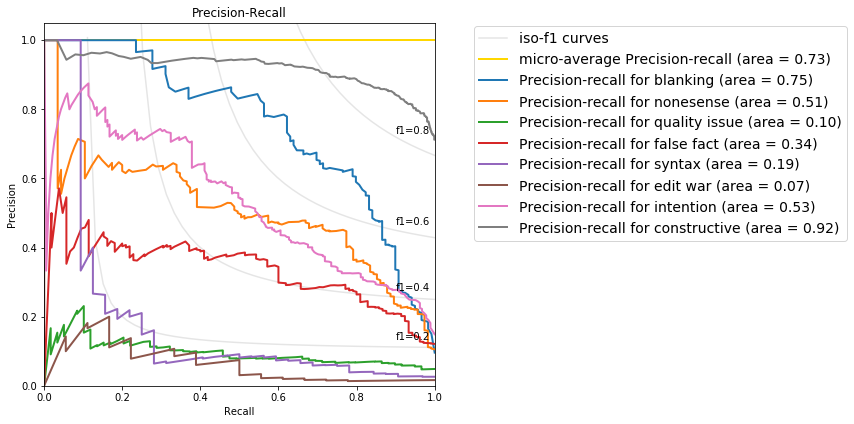

In [12]:
plot_multilabel_precision_recall(y_test, y_test_predict_proba, tag_names)

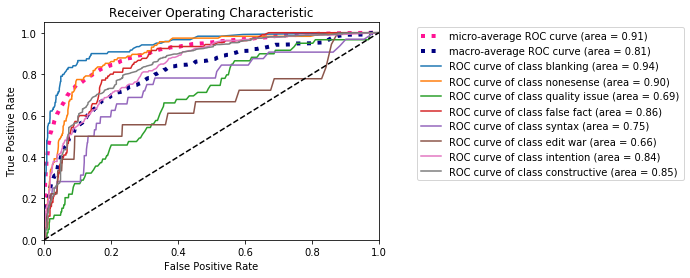

In [13]:
plot_multilabel_roc(y_test, y_test_predict_proba, tag_names)